## Import packeges and data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt

In [ ]:
PATH_ROOT = "/content/drive/MyDrive/gdrive_folder/Courses/course70938ML/Tutoring02/" # Make sure this is the right path, e.g., by !ls of this path

In [ ]:
df = pd.read_csv(PATH_ROOT+'AQbench_dataset_modified.csv')

In [ ]:
# present the dataframe
df

,lon,lat,alt,relative_alt,water_25km,evergreen_needleleaf_forest_25km,evergreen_broadleaf_forest_25km,deciduous_needleleaf_forest_25km,deciduous_broadleaf_forest_25km,mixed_forest_25km,...,no2_column,population_density,max_population_density_5km,max_population_density_25km,nightlight_1km,nightlight_5km,max_nightlight_25km,o3_average_values,o3_category,dataset
0,8.308210,54.924970,12.0,3,86.1,0.0,0.0,0.0,0.0,0.0,...,2.270,953,953,1017,46,20.73000,56,33.4050,1,test
1,12.725280,54.436670,1.0,1,55.7,1.2,0.0,0.0,0.0,8.7,...,2.310,349,386,6619,9,6.38000,60,29.8555,-1,train
2,6.093923,50.754704,205.0,66,0.0,1.9,0.0,0.0,0.0,32.8,...,7.060,14514,20125,26839,48,46.87000,62,23.8597,-1,train
3,8.548389,52.023169,102.0,29,0.0,0.0,0.0,0.0,0.0,11.4,...,5.230,16176,16191,16191,60,54.30000,62,20.3253,-1,test
4,6.874554,51.862000,45.0,8,0.0,0.0,0.0,0.0,0.0,18.5,...,7.990,3566,3569,12635,48,24.14000,58,21.4072,-1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5572,11.027920,49.322730,344.0,37,0.0,7.8,0.0,0.0,0.0,40.7,...,4.570,10640,14944,36792,39,29.19580,63,18.7670,-1,train
5573,11.850274,52.602056,35.0,5,0.0,8.1,0.0,0.0,0.0,14.8,...,3.160,1261,1262,1315,47,23.37090,52,26.3113,-1,train
5574,11.091078,51.456071,143.0,13,0.0,0.0,0.0,0.0,1.6,26.4,...,3.205,1126,1129,1748,8,7.64238,54,23.5591,-1,val
5575,13.420573,48.947611,858.0,76,0.0,15.7,0.0,0.0,0.0,54.2,...,2.090,1162,1163,1932,0,5.41958,45,35.6457,1,train


## Preproccesing

In [ ]:
# split the df to 3 dfs of train, valid and test
df_train = df[df['dataset']=='train']
df_val = df[df['dataset']=='val']
df_test = df[df['dataset']=='test']

Numpy arrays of each dfs part

In [ ]:
label_col = 'o3_average_values'
feature_cols = [col for col in df.columns if (is_numeric_dtype(df[col]) and ('o3' not in col))] # all columns except not numeric & "03"

X_train = np.array([df_train[col] for col in feature_cols]).T # numpy array of all columns and transpose it
y_train = np.array(df_train[label_col]) #labels of train
X_val = np.array([df_val[col] for col in feature_cols]).T
y_val = np.array(df_val[label_col])
X_test = np.array([df_test[col] for col in feature_cols]).T
y_test = np.array(df_test[label_col])
print(f"As we can see we have {X_train.shape[0]} rows of train and {X_train.shape[1]} features.")
print(f"We have {X_test.shape[0]} rows of test and {X_test.shape[1]} features.")
print(f"We have {X_val.shape[0]} rows of validation and {X_val.shape[1]} features.\n")
print("The Y is the label for each row...")

As we can see we have 3348 rows of train and 31 features.
We have 1115 rows of test and 31 features.
We have 1114 rows of validation and 31 features.

The Y is the label for each row...


Scale feature data using standardization

In [ ]:
X_mean = np.mean(X_train, axis=0) # Array witch contain mean of each column
X_std = np.std(X_train, axis=0) 
X_std[X_std==0] = 1 # To handle features with a zero std
X_train_scale = (X_train-X_mean)/X_std
X_val_scale = (X_val-X_mean)/X_std
X_test_scale = (X_test-X_mean)/X_std

## Define the functions

Linear prediction function

In [ ]:
def predict(X,w,b): 
  """Linear model prediction.
  X: a matix of nxm 
  where n is the number of examples and m number of features
  w: a vector of m weights
  b: bias
  """
  return (np.matmul(X,w)+b) 

MSE loss function

In [ ]:
def loss_mse(y_ex, y_pred_ex):
  """mse loss of one example"""
  return 0.5*np.power((y_ex-y_pred_ex),2) #MSE =0.5*(y' - y)^2

def empirical_risk(y, y_pred, lossf):
  "Empirical risk as the average of a loss function over all examples"
  emp_risk = np.mean([lossf(y[i], y_pred[i]) for i in range(len(y))])
  return emp_risk

Gradients of loss functions and their mean (i.e., gradients of the empirical risk)

In [ ]:
# for 1 example
def grad_mse_loss(x,w,b,y):
  """Gradients of the mse loss function for one example.
  x: a vector of m feature values 
  w: a vector of m weights
  b: bias
  y: label
  """
  gradw = x*(np.matmul(x,w)+b - y)
  gradb = (np.matmul(x,w)+b-y)


  return gradw, gradb


# for each batch

def mean_grad(X,w,b,y,grad_lossf):
  """Mean gradient of a loss function over n examples.
  X: a matix of nxm 
  where n is the number of examples and m is the number of features
  w: a vector of m weights
  b: bias
  y: a vector of n labels
  """
  mgradw = np.zeros_like(w)
  mgradb = 0
  for i in range(len(y)):
    gradw, gradb = grad_lossf(X[i,:],w,b,y[i])
    mgradw += gradw 
    mgradb += gradb
  mgradw = mgradw / len(y)
  mgradb = mgradb / len(y)

  return mgradw, mgradb

## 1.4

In [ ]:
#@title Batch gradient descent algorithm
eta = 0.1 # Learning rate hyperparameter
epoch_num = 50 # Epoch_num hperparameter

w = np.zeros(X_train_scale.shape[1]) + 0 # Initial weight values, can be done randomly
b = 0 # Initial bias value, can be done randomly
ls = []
for epoch in range(epoch_num):
  y_pred = predict(X_train_scale,w,b) 
  emp_risk = empirical_risk(y_train, y_pred, loss_mse)
  y_pred_val = predict(X_val_scale,w,b) 
  emp_risk_val = empirical_risk(y_val, y_pred_val, loss_mse)
  gradw,gradb = mean_grad(X_train_scale,w,b,y_train,grad_mse_loss)
  w = w - eta*gradw
  b = b - eta*gradb
  print(epoch, emp_risk, emp_risk_val) # You can comment this to avoid printing
  ls.append([epoch, w, b, gradw, gradb, emp_risk, emp_risk_val])

df_res_batch = pd.DataFrame(data=ls, columns=['Epoch', 'w', 'b', 'gradw', 'gradb', 'Emp_risk_train', 'Emp_risk_val'])

0 405.14820867064213 412.4765709698788
1 327.0321242126771 332.393287031574
2 266.2501384242492 270.4668998385537
3 217.46594089731016 221.0038896630005
4 178.0631764445326 181.15117795956638
5 146.18730454321795 148.94417650398884
6 120.38496991081345 122.878942699589
7 99.49189018729103 101.76602057507452
8 82.5701060513768 84.65362794191323
9 68.8623916604756 70.77631211024226
10 57.7567386903681 59.51690791291051
11 48.758151865540036 50.377094027199995
12 41.466082324133254 42.954143749657376
13 35.556297947754075 36.92238358336425
14 30.76628033695518 32.01832744694606
15 26.883441919096757 28.028721391395408
16 23.73560730827092 24.78091095476101
17 21.18331757680423 22.135070437303884
18 19.11360485697734 19.97792894136152
19 17.434954397121913 18.217701816607672
20 16.073226456710582 16.779994061727354
21 14.968354523341416 15.604488124549862
22 14.071671686091706 14.642265135305594
23 13.343745428497337 13.853637905117544
24 12.752624015359801 13.20639754340626
25 12.27241613

<function matplotlib.pyplot.show>

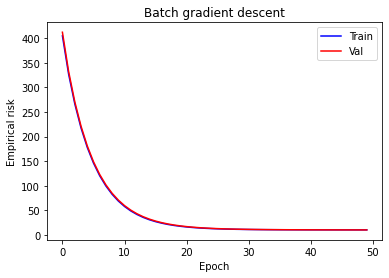

In [ ]:
# Plot learning curves
plt.plot(df_res['Epoch'], df_res['Emp_risk_train'], 'b')
plt.plot(df_res['Epoch'], df_res['Emp_risk_val'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Empirical risk')
plt.title("Batch gradient descent")
plt.legend(['Train', 'Val'])
plt.show

In [ ]:
# For evalute the model:
rmsd = {"Train":0,"Val":0,"Test":0}
bias = {"Train":0,"Val":0,"Test":0}

#for the graph later:
predictions = {"Train":0,"Val":0,"Test":0} 
labels = {"Train":0,"Val":0,"Test":0}

for (X,y,text) in [(X_train_scale,y_train,'Train'), (X_val_scale, y_val,'Val'), (X_test_scale, y_test,'Test')]:

  y_pred = predict(X,w,b)
  rmsd[text] += (np.power((y_pred -y),2))
  bias[text]+=(y_pred -y)
  predictions[text]+= y_pred
  labels[text]+=y

#Caculate bias and RMSD 
print("RMSD:")
for dataset_name in rmsd.keys():
  rmsd[dataset_name] = round((np.sum(rmsd[dataset_name])/len(rmsd[dataset_name]))**0.5,3)
print(rmsd)

print("bias:") 
for dataset_name in bias.keys():
  bias[dataset_name] = round(np.sum(bias[dataset_name])/len(bias[dataset_name]),3)
print(bias)

RMSD:
{'Train': 4.506, 'Val': 4.483, 'Test': 5.007}
bias:
{'Train': -0.143, 'Val': -0.434, 'Test': -0.057}


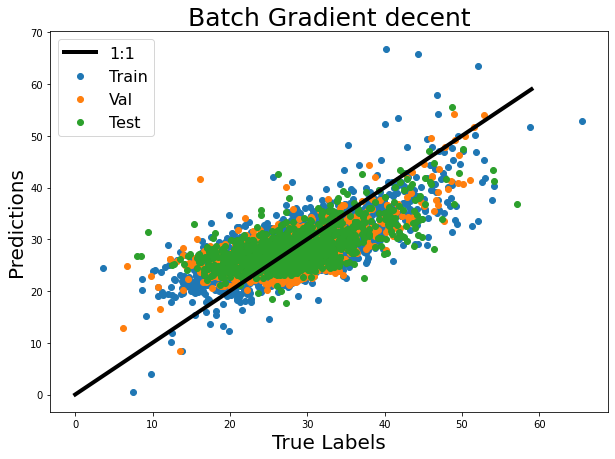

In [ ]:
a=np.arange(60)
fig, ax = plt.subplots(1, figsize=(10,7))
# for dataset in rmsd.keys():
ax.scatter(labels["Train"], predictions["Train"], label="Train")
ax.scatter(labels["Val"], predictions["Val"], label="Val")
ax.scatter(labels["Test"], predictions["Test"], label="Test")
ax.plot(a,a,color = "black",lw = 4,label= "1:1")
ax.set_xlabel("True Labels",fontsize = 20)
ax.set_ylabel("Predictions", fontsize = 20)
ax.set_title("Batch Gradient decent",fontsize = 25)
# legend
ax.legend(loc='best',fontsize = 16)

In [ ]:
#@title Stochastic gradient descent algorithm
eta = 0.0001 # Learning rate hyperparameter
epoch_num = 50 # Epoch_num hperparameter

w = np.zeros((X_train_scale.shape[1])) + 0 # Initial weight values, can be done randomly
b = 0 # Initial bias value, can be done randomly

ls = []
for epoch in range(epoch_num):
  # Shuffle examples (you can produce a random permutation of the index)
  # For each example: update weights and bias based on gradient loss of the single example
  randind = np.random.permutation(np.shape(X_train_scale)[0])
  for i in randind:
    gradw,gradb = grad_mse_loss(X_train_scale[randind[i],:],w,b,y_train[randind[i]])
    w = w - eta*gradw
    b = b - eta*gradb

  y_pred = predict(X_train_scale,w,b) 
  emp_risk = empirical_risk(y_train, y_pred, loss_mse)
  y_pred_val = predict(X_val_scale,w,b) 
  emp_risk_val = empirical_risk(y_val, y_pred_val, loss_mse)
  print(epoch, emp_risk, emp_risk_val) # You can comment this to avoid printing
  ls.append([epoch, w, b, gradw, gradb, emp_risk, emp_risk_val])
df_res_stochastic = pd.DataFrame(data=ls, columns=['Epoch', 'w', 'b', 'gradw', 'gradb', 'Emp_risk_train', 'Emp_risk_val'])

0 209.78915608985008 213.578994769381
1 112.26822857596642 114.63907765091213
2 62.492130971569985 64.3446911300776
3 37.06455307091992 38.50869028817824
4 24.016332218021926 25.102502360755732
5 17.312731169883435 18.10021966570111
6 13.855554800864759 14.404871159662191
7 12.078797241786273 12.458033589747634
8 11.1572241172892 11.4073854650991
9 10.684781160195644 10.831784136209587
10 10.435362519671742 10.510466779434234
11 10.299083615844305 10.311293985058528
12 10.225515074102223 10.181496374391996
13 10.185017000846603 10.117831262572844
14 10.158754211520582 10.070203093537856
15 10.143822654795802 10.031120343284142
16 10.134784045515152 10.028306685869959
17 10.123200166372907 10.003004933524918
18 10.118689727525174 9.98116851382853
19 10.11207239120538 9.97117226651343
20 10.107593027229035 9.959451955042901
21 10.103841545679185 9.941095391153683
22 10.101489983442022 9.931497617537651
23 10.098081642010643 9.930576020568479
24 10.097282595258234 9.935582052309607
25 10.

<function matplotlib.pyplot.show>

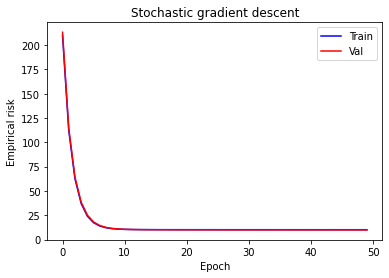

In [ ]:
# Plot learning curves
plt.plot(df_res['Epoch'], df_res['Emp_risk_train'], 'b')
plt.plot(df_res['Epoch'], df_res['Emp_risk_val'], 'r')
plt.title("Stochastic gradient descent")
plt.xlabel('Epoch')
plt.ylabel('Empirical risk')
plt.legend(['Train', 'Val'])
plt.show

In [ ]:
# For evalute the model:
rmsd = {"Train":0,"Val":0,"Test":0}
bias = {"Train":0,"Val":0,"Test":0}

#for the graph later:
predictions = {"Train":0,"Val":0,"Test":0} 
labels = {"Train":0,"Val":0,"Test":0}

for (X,y,text) in [(X_train_scale,y_train,'Train'), (X_val_scale, y_val,'Val'), (X_test_scale, y_test,'Test')]:

  y_pred = predict(X,w,b)
  rmsd[text] += (np.power((y_pred -y),2))
  bias[text]+=(y_pred -y)
  predictions[text]+= y_pred
  labels[text]+=y

#Caculate bias and RMSD 
print("RMSD:")
for dataset_name in rmsd.keys():
  rmsd[dataset_name] = round((np.sum(rmsd[dataset_name])/len(rmsd[dataset_name]))**0.5,3)
print(rmsd)

print("bias:") 
for dataset_name in bias.keys():
  bias[dataset_name] = round(np.sum(bias[dataset_name])/len(bias[dataset_name]),3)
print(bias)

RMSD:
{'Train': 4.489, 'Val': 4.443, 'Test': 5.031}
bias:
{'Train': -0.002, 'Val': -0.279, 'Test': 0.116}


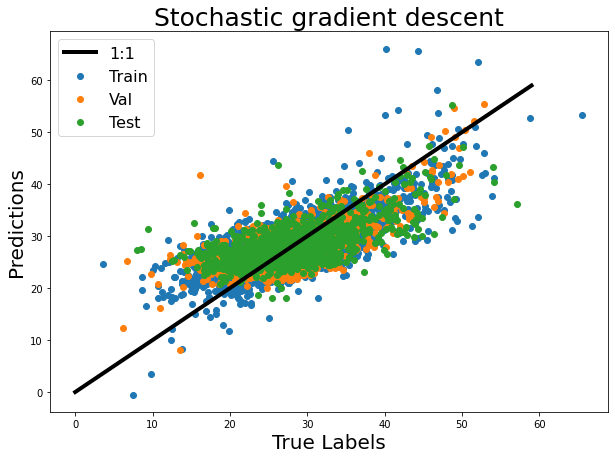

In [ ]:
a=np.arange(60)
fig, ax = plt.subplots(1, figsize=(10,7))
# for dataset in rmsd.keys():
ax.scatter(labels["Train"], predictions["Train"], label="Train")
ax.scatter(labels["Val"], predictions["Val"], label="Val")
ax.scatter(labels["Test"], predictions["Test"], label="Test")
ax.plot(a,a,color = "black",lw = 4,label= "1:1")
ax.set_xlabel("True Labels",fontsize = 20)
ax.set_ylabel("Predictions", fontsize = 20)
ax.set_title("Stochastic gradient descent",fontsize = 25)
# legend
ax.legend(loc='best',fontsize = 16)

In [ ]:
#@title Mini-batch gradient descent algorithm
eta = 0.001 # Learning rate hyperparameter
epoch_num = 50 # Epoch_num hperparameter
batch_size = 32 # Batch_size hyperparameter

w = np.zeros((X_train_scale.shape[1])) + 0 # Initial weight values, can be done randomly
b = 0 # Initial bias value, can be done randomly

ls = []
for epoch in range(epoch_num):
  # Shuffle examples (you can produce a random permutation of the index)
  # For each example: update weights and bias based on gradient loss of the single example
  randind = np.random.permutation(np.shape(X_train_scale)[0])
  for i in np.arange(0,len(randind),batch_size):
    gradw,gradb = mean_grad(X_train_scale[randind[i:i+batch_size],:],w,b,y_train[randind[i:i+batch_size]],grad_mse_loss)
    w = w - eta*gradw
    b = b - eta*gradb

  y_pred = predict(X_train_scale,w,b) 
  emp_risk = empirical_risk(y_train, y_pred, loss_mse)
  y_pred_val = predict(X_val_scale,w,b) 
  emp_risk_val = empirical_risk(y_val, y_pred_val, loss_mse)
  print(epoch, emp_risk, emp_risk_val) # You can comment this to avoid printing
  ls.append([epoch, w, b, gradw, gradb, emp_risk, emp_risk_val])

df_res_mini = pd.DataFrame(data=ls, columns=['Epoch', 'w', 'b', 'gradw', 'gradb', 'Emp_risk_train', 'Emp_risk_val'])

0 327.7524615575205 333.42445936560887
1 266.72832863901584 271.1897092814933
2 217.8483090005303 221.5605926284877
3 178.42955359795403 181.62845683187058
4 146.53989308779387 149.37948216442982
5 120.69862393534147 123.2603129343688
6 99.79224133711801 102.12031416461598
7 82.84141352731285 84.9729784391397
8 69.10050014677768 71.06225583970772
9 57.97250399340187 59.76994571410502
10 48.94987917839191 50.603646829898075
11 41.63878211537162 43.157477633999385
12 35.7077242903558 37.09858002343084
13 30.8978022228323 32.167439596473315
14 26.99733644426175 28.155003997916264
15 23.83247705344425 24.890060073652876
16 21.26828987433234 22.2323391413941
17 19.183826034793995 20.054265564879575
18 17.493556317329826 18.282600829713374
19 16.118507216714246 16.830602247537147
20 15.004869430209208 15.643568293042367
21 14.10231761803576 14.672922448625435
22 13.366474500761921 13.877341025304437
23 12.770030809437445 13.222535230363508
24 12.283908491096419 12.686643851423922
25 11.89035

<function matplotlib.pyplot.show>

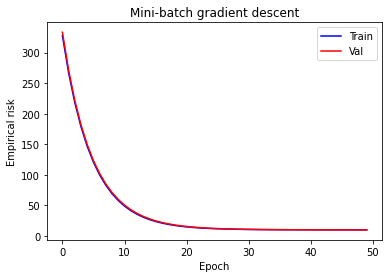

In [ ]:
# Plot learning curves
plt.plot(df_res['Epoch'], df_res['Emp_risk_train'], 'b')
plt.plot(df_res['Epoch'], df_res['Emp_risk_val'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Empirical risk')
plt.title("Mini-batch gradient descent")
plt.legend(['Train', 'Val'])
plt.show

In [ ]:
# For evalute the model:
rmsd = {"Train":0,"Val":0,"Test":0}
bias = {"Train":0,"Val":0,"Test":0}

#for the graph later:
predictions = {"Train":0,"Val":0,"Test":0} 
labels = {"Train":0,"Val":0,"Test":0}

for (X,y,text) in [(X_train_scale,y_train,'Train'), (X_val_scale, y_val,'Val'), (X_test_scale, y_test,'Test')]:

  y_pred = predict(X,w,b)
  rmsd[text] += (np.power((y_pred -y),2))
  bias[text]+=(y_pred -y)
  predictions[text]+= y_pred
  labels[text]+=y

#Caculate bias and RMSD 
print("RMSD:")
for dataset_name in rmsd.keys():
  rmsd[dataset_name] = round((np.sum(rmsd[dataset_name])/len(rmsd[dataset_name]))**0.5,3)
print(rmsd)

print("bias:") 
for dataset_name in bias.keys():
  bias[dataset_name] = round(np.sum(bias[dataset_name])/len(bias[dataset_name]),3)
print(bias)

RMSD:
{'Train': 4.505, 'Val': 4.482, 'Test': 5.008}
bias:
{'Train': -0.145, 'Val': -0.436, 'Test': -0.059}


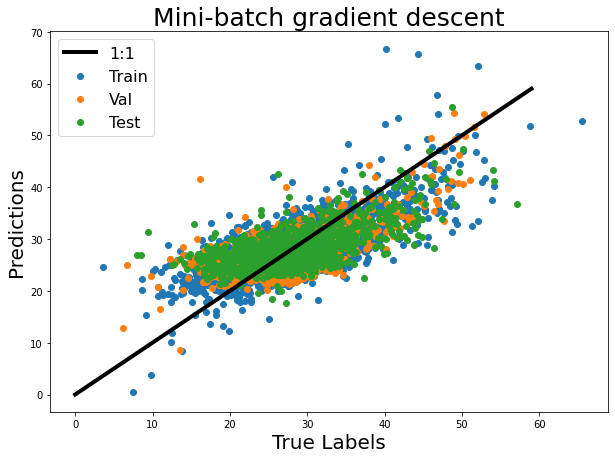

In [ ]:
a=np.arange(60)
fig, ax = plt.subplots(1, figsize=(10,7))
# for dataset in rmsd.keys():
ax.scatter(labels["Train"], predictions["Train"], label="Train")
ax.scatter(labels["Val"], predictions["Val"], label="Val")
ax.scatter(labels["Test"], predictions["Test"], label="Test")
ax.plot(a,a,color = "black",lw = 4,label= "1:1")
ax.set_xlabel("True Labels",fontsize = 20)
ax.set_ylabel("Predictions", fontsize = 20)
ax.set_title("Mini-batch gradient descent",fontsize = 25)
# legend
ax.legend(loc='best',fontsize = 16)

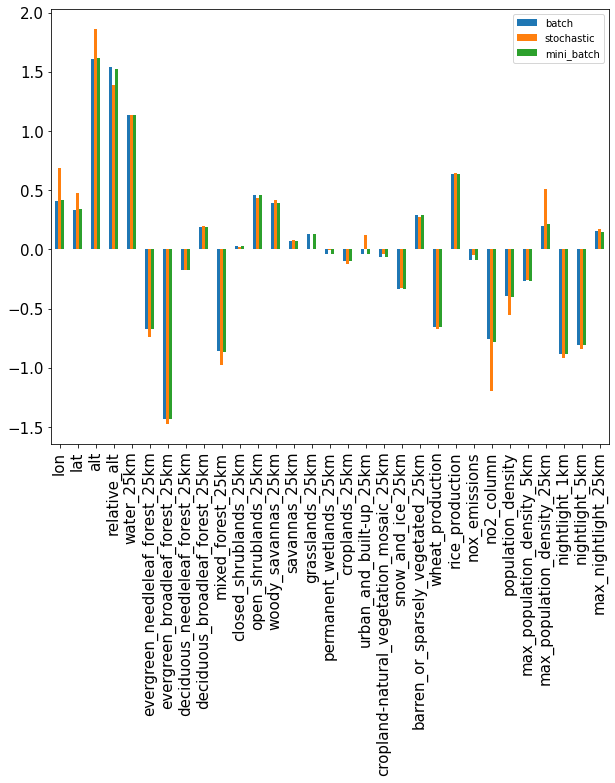

In [ ]:
# df with all the best wheiths:
df_w = pd.DataFrame(index=feature_cols)
df_w["batch"] = df_res_batch["w"].loc[49]
df_w["stochastic"] = df_res_stochastic["w"].loc[49]
df_w["mini_batch"] = df_res_mini["w"].loc[49]
import seaborn as sns
df_w.plot( y=["batch", "stochastic", "mini_batch"], kind="bar",figsize=(10,8),fontsize= 15)
plt.savefig("/content/drive/MyDrive/gdrive_folder/Courses/course70938ML/HW/weigths_graph.png")

In [ ]:
# export to excel
df_w.to_excel("/content/drive/MyDrive/gdrive_folder/Courses/course70938ML/HW/weigths.xlsx")  